In [11]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
# from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [ ]:
import pandas as pd
import yfinance as yf

# Fetch Historical Prices
def fetch_all_historical_prices(asset_symbol, start_date, end_date):
    try:
        data = yf.download(
            asset_symbol,
            start=start_date.strftime('%Y-%m-%d'),
            end=end_date.strftime('%Y-%m-%d'),
            progress=False
        )
        if data.empty:
            raise ValueError(f"No data found for {asset_symbol} between {start_date} and {end_date}.")
        data = data[['Close']].rename(columns={'Close': asset_symbol})
        data.columns = [asset_symbol]
        return data
    except Exception as e:
        print(f"Error fetching data for {asset_symbol}: {e}")
        return pd.DataFrame()
        
start_date = pd.to_datetime('2020-01-01')  # Adjusted to 2023 as future data may not be available
end_date = pd.to_datetime('2024-11-30')
ticker_list = ['CBU','^GDAXI', '^GSPC', 'GOOG', 'XLE', '^STOXX', '^N225', '^BSESN', '^FTSE', 'TXGE', 'BTC-USD']
for ticker in ticker_list:
    data = fetch_all_historical_prices(f"{ticker}", start_date, end_date)
    data['Close'] = data[ticker]
    data['Date'] = data.index
    data.index = range(len(data))
    data.to_csv(f'{ticker}_historical_data_ARIMA.csv')

In [43]:
def Arima(input, start_date, end_date):
    #divide into train and validation set
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    data = pd.read_csv(f'{input}_historical_data_ARIMA.csv')
    data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)
    ind_start = np.where(data['Date']>start_date)[0][0]   #np.argmax(np.abs(data['Date']-start_date)) 
    train = data[:ind_start]['Close']
    valid = data[ind_start:]['Close']
    # Train the ARIMA model on the training data
    arima_order = (4, 1, 4)  # ARIMA model order (p, d, q)
    model = ARIMA(train, order=arima_order)
    model.initialize_approximate_diffuse()
    model_fit = model.fit()
    print(model_fit.summary())
    
    # Rolling window prediction on the test data
    predictions = []
    window = list(train[-15:])  # Initialize the rolling window with the last 30 training observations
    
    for t in valid:
        # Fit ARIMA model on the current window
        # print(window)
        rolling_model = ARIMA(window, order=arima_order)
        rolling_model_fit = rolling_model.fit()
    
        # Forecast next value
        forecast = rolling_model_fit.forecast(steps=1)[0]
        predictions.append(forecast)
    
        # Update the rolling window
        window.append(t)
        window = window[-15:]  # Keep the window size constant
    result_df = pd.DataFrame({'Date':data['Date'][ind_start:], 'Actual Prices':valid, 'Predicted Prices': predictions})
    return result_df

In [45]:
start_date = pd.to_datetime('2024-01-01') 
end_date = pd.to_datetime('2024-11-30')
ticker_list = ['^GSPC']  #'^GDAXI',
for ticker in ticker_list:
    print(ticker, 'start')
    result_df = Arima(ticker, start_date, end_date)
    result_df.to_csv(f'Results/{ticker}_arima_predictions.csv')
    print(ticker, 'done')

^GSPC start
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1006
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -5337.263
Date:                Tue, 14 Jan 2025   AIC                          10692.526
Time:                        11:57:47   BIC                          10736.741
Sample:                             0   HQIC                         10709.327
                               - 1006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2751      0.044     -6.292      0.000      -0.361      -0.189
ar.L2          0.7833      0.043     18.116      0.000       0.699       0.868
ar.L3         -0.3741      0.040     -9.

In [47]:
def Evaluate(result_df, ticker):
    valid = result_df['Actual Prices']
    predictions = result_df['Predicted Prices']
    # Evaluate the model performance
    rmse = (mean_squared_error(valid, predictions))**0.5
    R2 = r2_score(valid, predictions)
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R2: {R2}")
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(result_df['Date'], valid, label="Actual Prices", color='blue')
    plt.plot(result_df['Date'], predictions, label="Predicted Prices", color='red', linestyle='--')
    # plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"{ticker}")
    plt.savefig(f'Plots/{ticker}_plot.png')
    plt.show()
    return rmse, R2

Root Mean Squared Error: 1.6681840563748564
R2: 0.9562294732064842


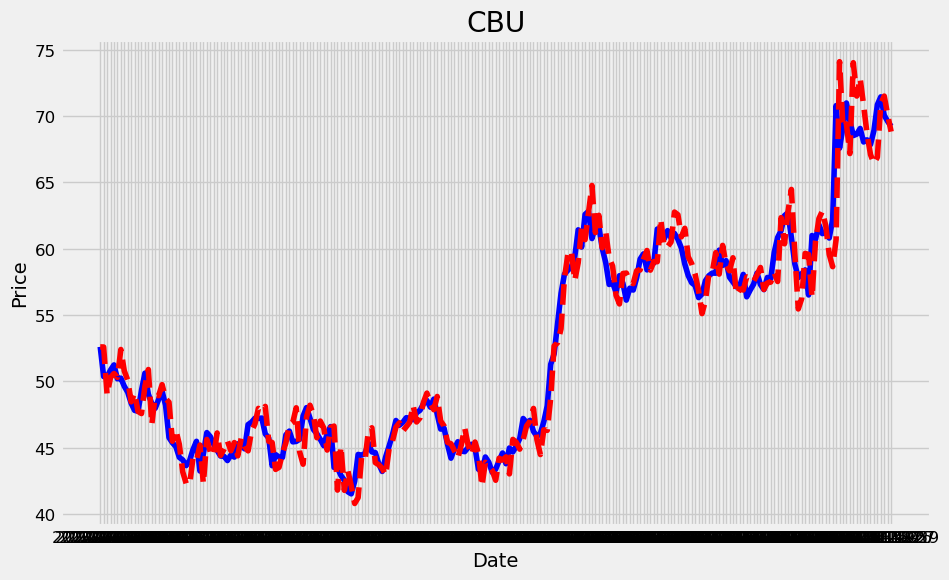

Root Mean Squared Error: 211.72573202310653
R2: 0.9304150538188248


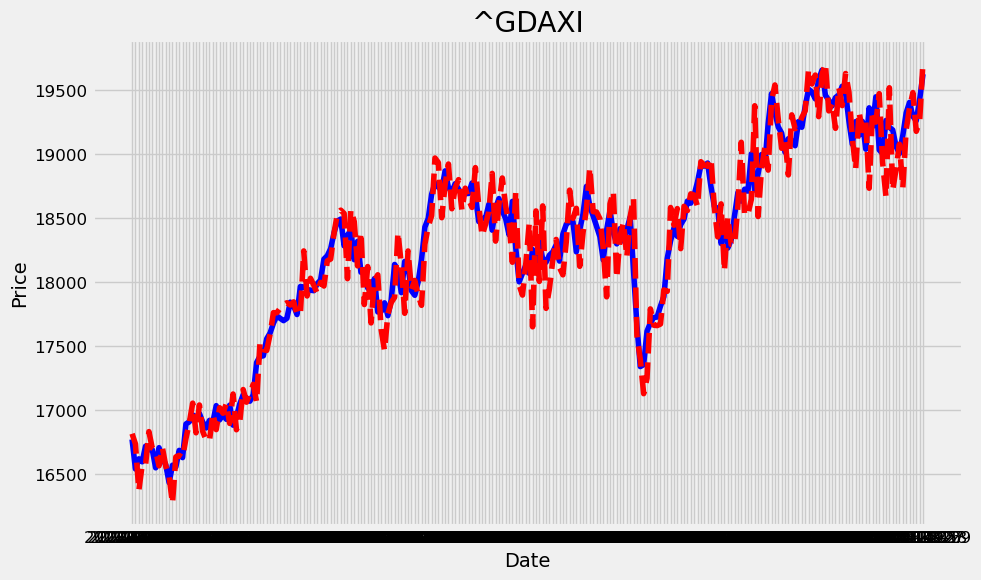

Root Mean Squared Error: 53.6039446103371
R2: 0.974581362844765


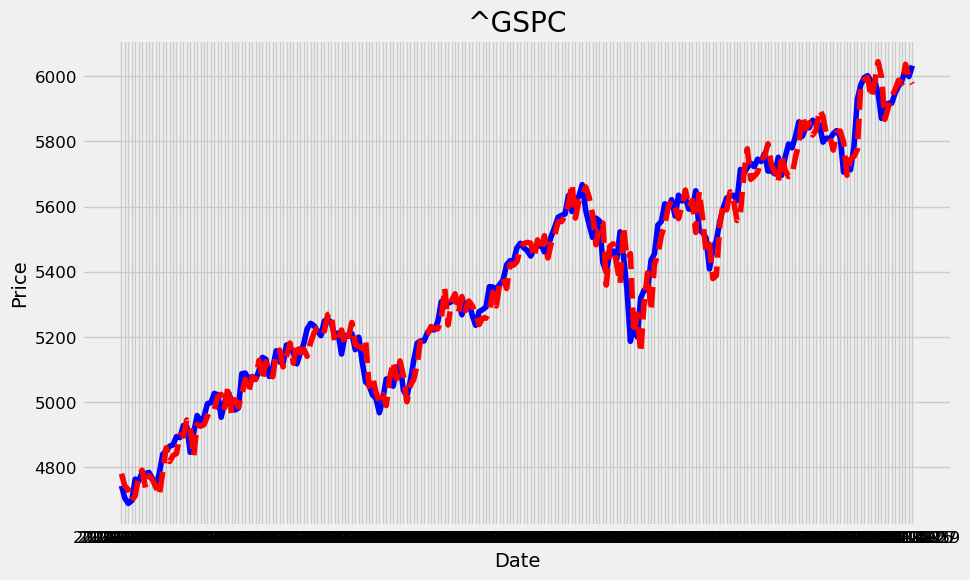

Root Mean Squared Error: 3.8061359997665627
R2: 0.9277778455554824


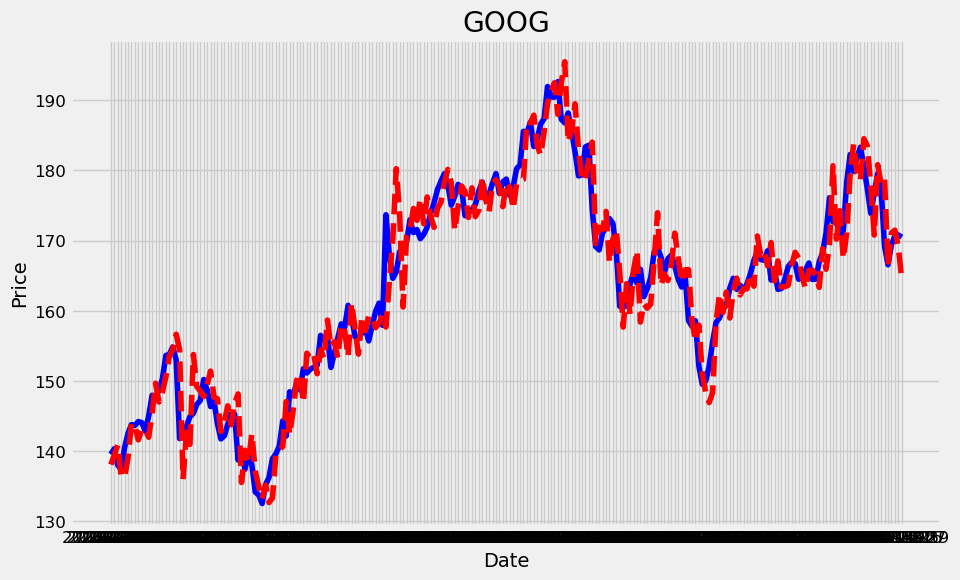

Root Mean Squared Error: 1.4228851013682977
R2: 0.8780626639504512


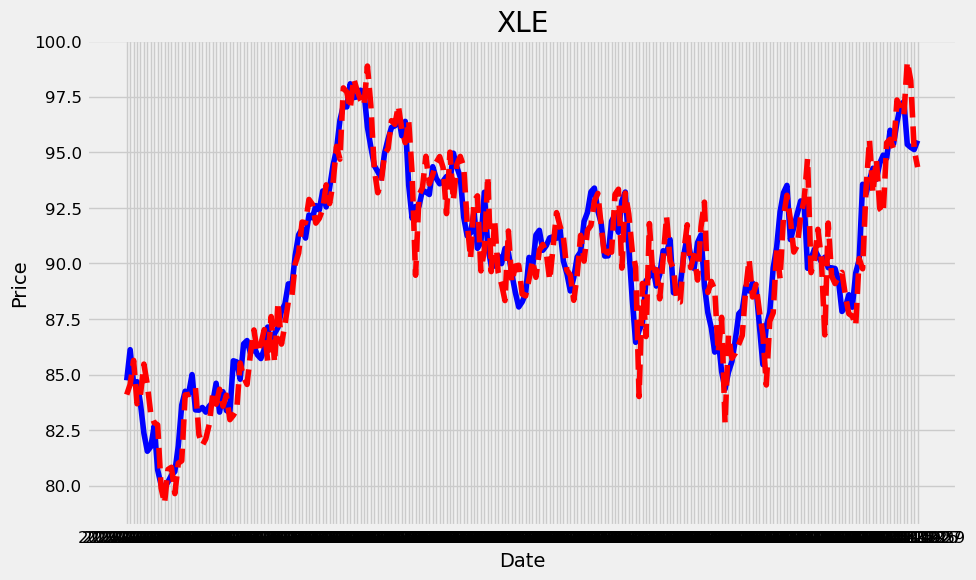

Root Mean Squared Error: 4.916202689807752
R2: 0.8745080267377935


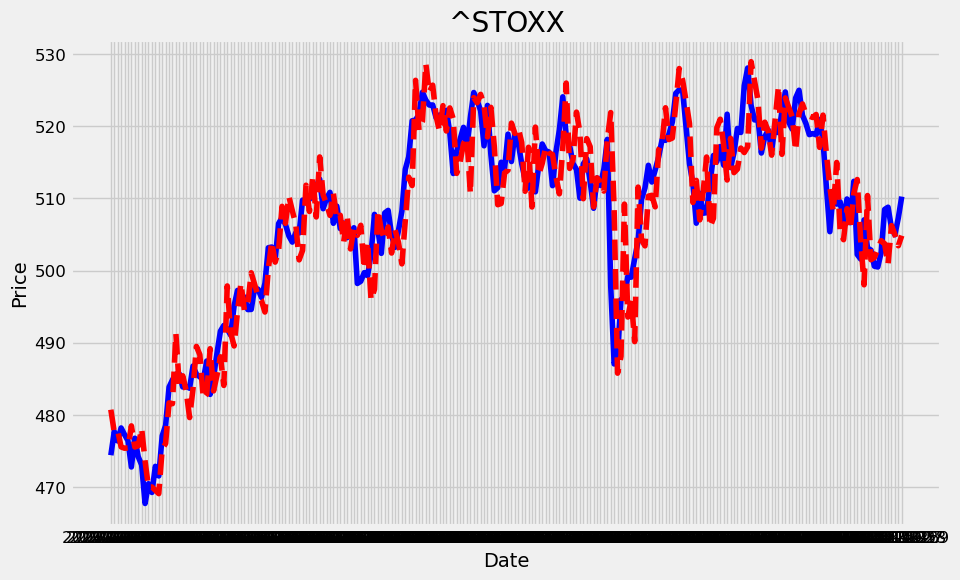

Root Mean Squared Error: 715.7150493113041
R2: 0.7999819256666388


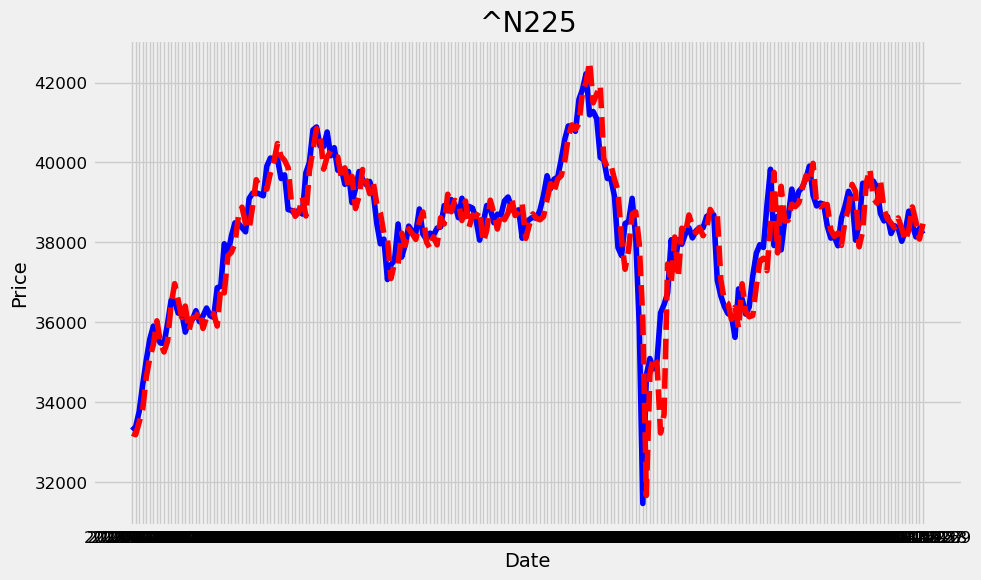

Root Mean Squared Error: 790.3234311557903
R2: 0.9622305796811466


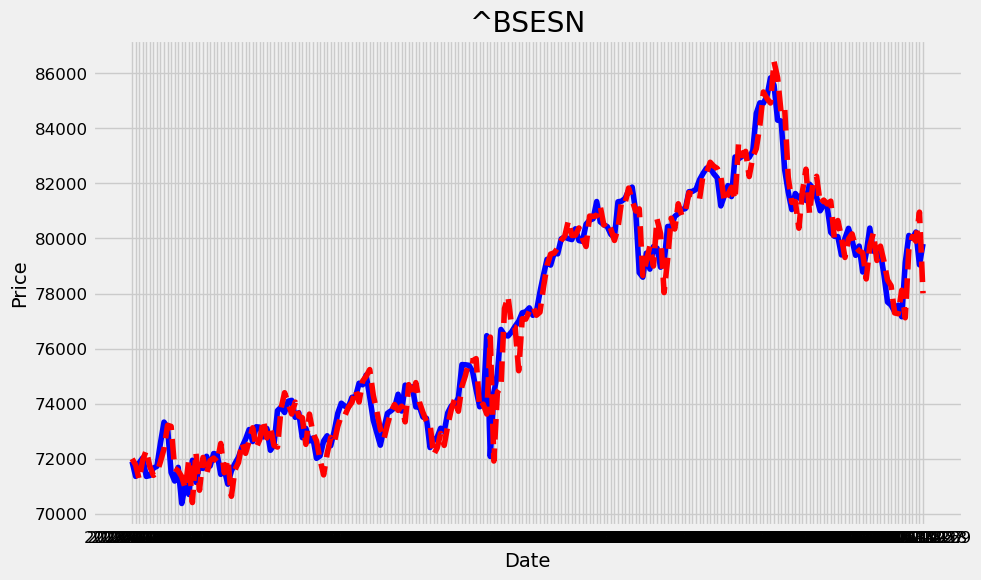

Root Mean Squared Error: 68.49653122723026
R2: 0.9357634473502039


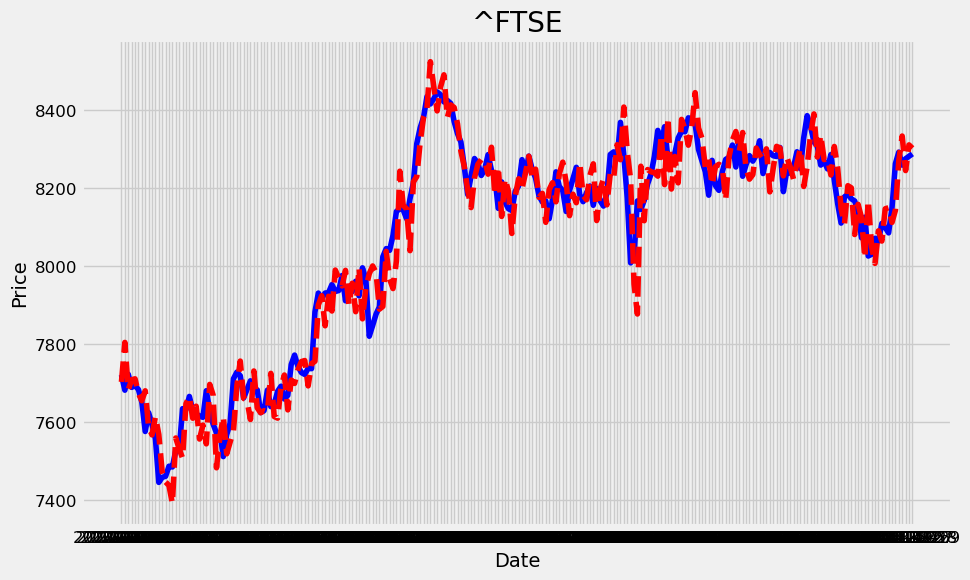

Root Mean Squared Error: 59.76865505947721
R2: 0.9715798437888864


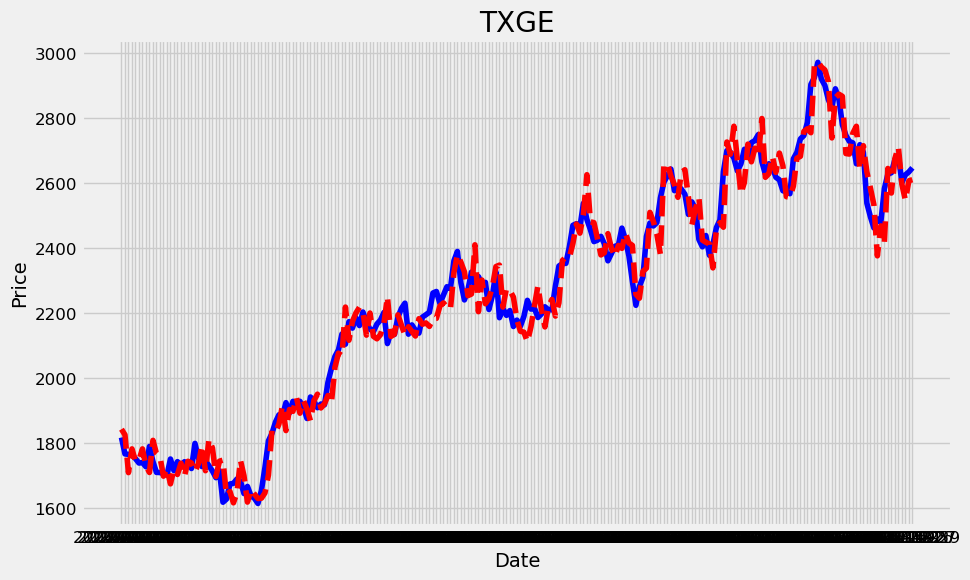

Root Mean Squared Error: 2870.098435993693
R2: 0.9340375709937941


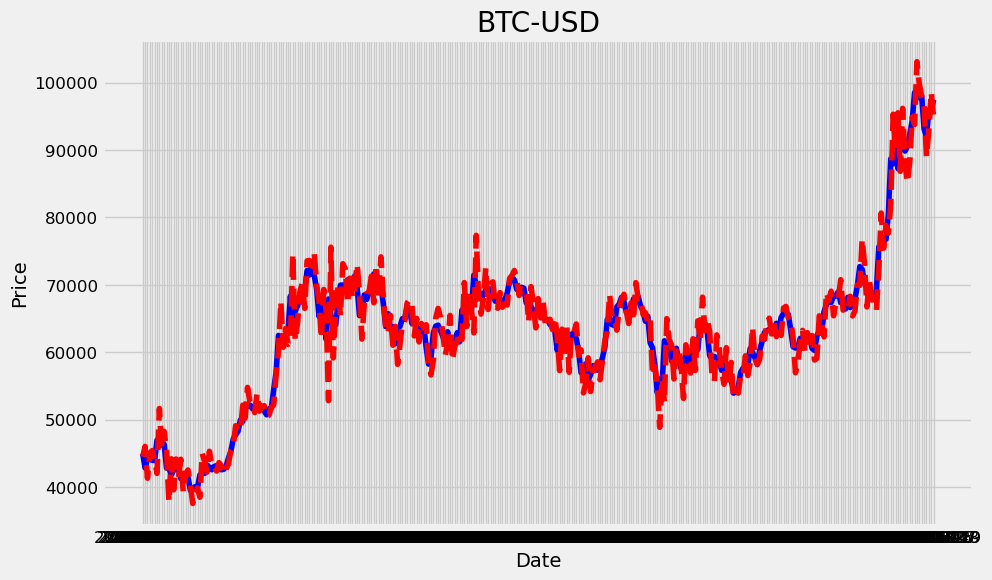

In [49]:
rmse_list = []
R2_list = []
ticker_list = ['CBU','^GDAXI', '^GSPC', 'GOOG', 'XLE', '^STOXX', '^N225', '^BSESN', '^FTSE', 'TXGE', 'BTC-USD']
for ticker in ticker_list:
    result_df = pd.read_csv(f'Results/{ticker}_arima_predictions.csv')
    rmse, R2 = Evaluate(result_df, ticker)
    rmse_list.append(rmse)
    R2_list.append(R2)
final_df = pd.DataFrame({'Ticker':ticker_list, 'RMSE_Arima':rmse_list, 'R2_Arima':R2_list})
final_df.to_csv('Compiled_results_arima.csv')

In [ ]:
data['Date'] = pd.to_datetime(data.index)
data.index = range(len(data))
data.head()

# ADF Test

In [ ]:
def test_stationarity(time_series: pd.Series) -> None:
    """
    Tests the stationarity of a time series using the Augmented Dickey-Fuller test.

    Args:
    time_series (pd.Series): The time series data to test for stationarity.
    """
    from statsmodels.tsa.stattools import adfuller

    result = adfuller(time_series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Assuming 'ts_log_moving_avg_diff' is defined and you want to drop NaN values
AD_test_data = data['GOOG'].diff().dropna()

# Now call the test_stationarity function
test_stationarity(AD_test_data)

# ACF & PACF

In [ ]:
ts = data['GOOG'].diff()
ts.dropna(inplace=True)

In [ ]:
plt.figure()
plt.subplot(211)
plot_acf(ts, ax=plt.gca(),lags=30)
plt.subplot(212)
plot_pacf(ts, ax=plt.gca(),lags=30)
plt.tight_layout()
plt.show()

# Train/Test Split

In [ ]:
#divide into train and validation set
train = data[:int(0.75*(len(data)))]['GOOG']
valid = data[int(0.75*(len(data))):]['GOOG']

#plotting the data
train.plot()
valid.plot()

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error

# # Load your stock data
# # Replace 'your_stock_data.csv' with your dataset
# # Ensure the dataset has a datetime column (e.g., 'Date') and a price column (e.g., 'Close')
# data = pd.read_csv("your_stock_data.csv")
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

# # Select the target variable (e.g., 'Close')
# prices = data['Close']

# # Parameters for rolling window and ARIMA
# rolling_window_size = 15  # Number of observations in the rolling window
# arima_order = (5, 1, 5)   # ARIMA model order (p, d, q)

# # Lists to store results
# predictions = []
# test_values = []

# # Rolling window prediction
# for i in range(rolling_window_size, len(prices)):
#     # Create the rolling window train data
#     train = prices[i - rolling_window_size:i]
#     test = prices[i]

#     # Fit ARIMA model
#     model = ARIMA(train, order=arima_order)
#     model_fit = model.fit()

#     # Forecast next value
#     forecast = model_fit.forecast(steps=1)[0]

#     # Store results
#     predictions.append(forecast)
#     test_values.append(test)

# # Convert results to numpy arrays
# predictions = np.array(predictions)
# test_values = np.array(test_values)

# # Evaluate the model performance
# mse = mean_squared_error(test_values, predictions)
# print(f"Mean Squared Error: {mse}")

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(prices.index[rolling_window_size:], test_values, label="Actual Prices", color='blue')
# plt.plot(prices.index[rolling_window_size:], predictions, label="Predicted Prices", color='red')
# plt.legend()
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.title("Stock Price Prediction using ARIMA")
# plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error



# Train the ARIMA model on the training data
arima_order = (5, 1, 5)  # ARIMA model order (p, d, q)
model = ARIMA(train, order=arima_order)
model_fit = model.fit()
print(model_fit.summary())

# Rolling window prediction on the test data
predictions = []
window = list(train[-15:])  # Initialize the rolling window with the last 30 training observations

for t in valid:
    # Fit ARIMA model on the current window
    rolling_model = ARIMA(window, order=arima_order)
    rolling_model_fit = rolling_model.fit()

    # Forecast next value
    forecast = rolling_model_fit.forecast(steps=1)[0]
    predictions.append(forecast)

    # Update the rolling window
    window.append(t)
    window = window[-30:]  # Keep the window size constant

In [ ]:
# Evaluate the model performance
rmse = (mean_squared_error(valid, predictions))**0.5
R2 = r2_score(valid, predictions)
print(f"Mean Squared Error: {rmse}")
print(f"Mean Squared Error: {R2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(valid.index, valid, label="Actual Prices", color='blue')
plt.plot(valid.index, predictions, label="Predicted Prices", color='red')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Price Prediction using ARIMA with Rolling Window")
plt.show()

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_sarima_model(train, order, seasonal_order):
    """
    Fits a SARIMA model to the given training data.

    Args:
    train (pd.Series): The training time series data.
    order (tuple): The (p, d, q) order of the model.
    seasonal_order (tuple): The (P, D, Q, s) seasonal order of the model.

    Returns:
    SARIMAX: The fitted SARIMA model.
    """
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    return model_fit

# Example usage (assuming 'train' is defined and is a pandas Series):
order = (4, 1, 4)  # Non-seasonal order
seasonal_order = (4, 1, 4, 5)  # Seasonal order (P, D, Q, s)
model_fit = fit_sarima_model(train, order, seasonal_order)

# Print the summary of the model
print(model_fit.summary())

In [ ]:
start_index = valid.index.min()
end_index = valid.index.max()
print(start_index, end_index)

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [ ]:
# report performance
mse = mean_squared_error(data[start_index:]['GOOG'], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

In [ ]:
plt.plot(data['GOOG'])
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

In [ ]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

# Tuned SARIMA

In [ ]:
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

In [ ]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)

In [ ]:
pred_ci = pred.conf_int()
ax = data['GOOG'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

# Auto ARIMA

In [ ]:
import pandas as pd
from pmdarima import auto_arima

def build_auto_arima_model(train: pd.Series, seasonal: bool = True, m: int = 3) -> auto_arima:
    """
    Builds an ARIMA model automatically using the auto_arima function.

    Args:
    train (pd.Series): The training time series data.
    seasonal (bool): Whether to include seasonal components in the model.
    m (int): The number of periods in each season (e.g., 12 for monthly data).

    Returns:
    auto_arima: The fitted ARIMA model.
    """
    model = auto_arima(train, trace=True, error_action='ignore', 
                        suppress_warnings=True, seasonal=seasonal, m=m, stepwise=True)
    model.fit(train)
    return model

# Example usage (assuming 'train' is defined and is a pandas Series):
model = build_auto_arima_model(train)

# Print the summary of the model
print(model.summary())

In [ ]:
start_index = valid.index.min()
end_index = valid.index.max()
print(start_index, end_index)

#Predictions
predictions = model.predict(start=start_index, end=end_index)

In [ ]:
predictions

In [ ]:
# report performance
mse = mean_squared_error(data[start_index:]['GOOG'], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

In [ ]:
plt.plot(data['GOOG'])
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

In [ ]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())